<a href="https://colab.research.google.com/github/robinanwyl/breast_cancer_classifier/blob/main/BENG203_CSE283_DiffExpr_FeatureSets.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# BENG 203/CSE 283 SP25 Final Project - Breast Cancer Classifier - Differential Expression Analysis and Curation of Biology-Inspired Feature Sets

-  QC, preprocessing, and differential expression analysis on SILVER-seq paper breast cancer dataset
-  Curating feature sets from regulons (known BC TFs and target gene interactions) and known breast cancer gene panels


***

Mount Drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
filepath = "/content/drive/My Drive/BENG203_CSE283_Project/"

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Clone GitHub repo

In [ ]:
%%bash
cd "/content/drive/My Drive/BENG203_CSE283_Project/"
mkdir -p breast_cancer_classifier
cd breast_cancer_classifier
git clone https://github.com/robinanwyl/breast_cancer_classifier.git

Cloning into 'breast_cancer_classifier'...


Install packages

In [ ]:
%%capture
%pip install decoupler
%pip install biothings-client

In [ ]:
%%capture
%pip install pydeseq2
%pip install decoupler
%pip install biothings-client

Import statements

In [ ]:
import pandas as pd
import decoupler as dc
from biothings_client import get_client

In [ ]:
from pydeseq2.dds import DeseqDataSet
from pydeseq2.ds import DeseqStats
from pydeseq2.default_inference import DefaultInference
import decoupler as dc
from biothings_client import get_client

Read in data

In [ ]:
# Cancer data
cancer_tpm = pd.read_csv(f"{filepath}/Data/pnas_tpm_96_nodup.txt", sep="\t", header=None)
cancer_read_counts = pd.read_csv(f"{filepath}/Data/pnas_readcounts_96_nodup.txt", sep="\t", header=None)
# Normal data
normal_tpm = pd.read_csv(f"{filepath}/Data/pnas_normal_tpm.txt", sep="\t")
normal_read_counts = pd.read_csv(f"{filepath}/Data/pnas_normal_readcounts.txt", sep="\t")

## Identify exRNAs from TPM data

exRNAs are defined as having TPM > 5. We will filter for the genes corresponding to exRNAs. Then we will perform differential expression analysis on the filtered sample x (exRNA gene) dataset.

In [ ]:
# Make sure datasets are formatted the same way
cancer_tpm = cancer_tpm.T
cancer_tpm.columns = cancer_tpm.iloc[0]
cancer_tpm = cancer_tpm.drop(0)
normal_tpm = normal_tpm.T

In [ ]:
cancer_tpm.head(3)

,ENSG00000000003,ENSG00000000005,ENSG00000000419,ENSG00000000457,ENSG00000000460,ENSG00000000938,ENSG00000000971,ENSG00000001036,ENSG00000001084,ENSG00000001167,...,ENSG00000283098,ENSG00000283101,ENSG00000283103,ENSG00000283108,ENSG00000283110,ENSG00000283117,ENSG00000283118,ENSG00000283122,ENSG00000283123,ENSG00000283125
1,7.071605,13.279391,0.0,6.212355,34.038592,9.231355,32.811263,19.136966,12.631348,11.220057,...,12.308474,0.0,4.430132,0.0,0.0,6.856902,16.599238,22.357146,0.0,19.542796
2,60.610797,47.42408,0.0,2.21859,35.828348,4.395669,22.498053,0.0,5.41317,48.083612,...,8.791338,0.0,0.0,48.996429,0.0,9.795095,0.0,4.56246,0.0,0.0
3,58.255903,60.455497,23.040206,12.120963,55.926653,8.005046,13.657227,14.9353,16.430065,14.594347,...,0.0,0.0,0.0,14.871406,0.0,13.378542,0.0,12.463189,0.0,0.0


In [ ]:
normal_tpm.head(3)

,ENSG00000000003,ENSG00000000005,ENSG00000000419,ENSG00000000457,ENSG00000000460,ENSG00000000938,ENSG00000000971,ENSG00000001036,ENSG00000001084,ENSG00000001167,...,ENSG00000283098,ENSG00000283101,ENSG00000283103,ENSG00000283108,ENSG00000283110,ENSG00000283117,ENSG00000283118,ENSG00000283122,ENSG00000283123,ENSG00000283125
N1,26.432148,24.817762,66.208114,8.127159,8.035515,16.102255,20.603770,8.583587,15.108249,6.290726,...,13.801933,0.0,3.311778,0.00000,0.0,0.000000,12.408881,14.325640,0.0,0.000000
N2,17.260895,5.402219,0.000000,6.318156,20.406574,2.503619,4.271368,6.228123,9.249458,15.975601,...,0.000000,0.0,3.604465,111.62661,0.0,0.000000,0.000000,20.788941,0.0,0.000000
N3,0.000000,7.557640,10.081027,15.910242,0.000000,17.512665,0.000000,0.000000,23.004230,0.000000,...,0.000000,0.0,0.000000,0.00000,0.0,27.317062,0.000000,0.000000,0.0,177.956852


In [ ]:
# Concatenate
tpm_df = pd.concat([cancer_tpm, normal_tpm])
tpm_df.head(3)

,ENSG00000000003,ENSG00000000005,ENSG00000000419,ENSG00000000457,ENSG00000000460,ENSG00000000938,ENSG00000000971,ENSG00000001036,ENSG00000001084,ENSG00000001167,...,ENSG00000283098,ENSG00000283101,ENSG00000283103,ENSG00000283108,ENSG00000283110,ENSG00000283117,ENSG00000283118,ENSG00000283122,ENSG00000283123,ENSG00000283125
1,7.071605,13.279391,0.0,6.212355,34.038592,9.231355,32.811263,19.136966,12.631348,11.220057,...,12.308474,0.0,4.430132,0.0,0.0,6.856902,16.599238,22.357146,0.0,19.542796
2,60.610797,47.42408,0.0,2.21859,35.828348,4.395669,22.498053,0.0,5.41317,48.083612,...,8.791338,0.0,0.0,48.996429,0.0,9.795095,0.0,4.56246,0.0,0.0
3,58.255903,60.455497,23.040206,12.120963,55.926653,8.005046,13.657227,14.9353,16.430065,14.594347,...,0.0,0.0,0.0,14.871406,0.0,13.378542,0.0,12.463189,0.0,0.0


In [ ]:
# Filter columns with sum < 5
print(f"Number of genes in TPM dataset before filtering: {tpm_df.shape[1]}")
tpm_exrna_df = tpm_df.loc[:,tpm_df.sum(axis=0) > 5]
print(f"Number of genes in TPM dataset after filtering: {tpm_exrna_df.shape[1]}")
exrna_list = tpm_exrna_df.columns.tolist()
print(f"Number of exRNAs in cancer TPM dataset: {len(exrna_list)}")

Number of genes in TPM dataset before filtering: 60675
Number of genes in TPM dataset after filtering: 56877
Number of exRNAs in cancer TPM dataset: 56877


## Differential Expression Analysis

Here, we will perform differential expression analysis on the sample x exRNA gene dataset using PyDESeq2, based on this [PyDESeq2 tutorial](https://pydeseq2.readthedocs.io/en/stable/auto_examples/plot_minimal_pydeseq2_pipeline.html). PyDESeq2 is the Python implementation of the R package DESeq2; this [DESeq2 tutorial](https://hbctraining.github.io/DGE_workshop_salmon/lessons/05_DGE_DESeq2_analysis2.html) from the HBC Training Program provides more background and context on the methods we will use.

PyDESeq2 uses raw read counts as input. It takes data as a sample x gene matrix and metadata as a sample x info matrix.

### Preprocessing

First we read in, transpose, format, and view both datasets.

In [ ]:
cancer_read_counts = cancer_read_counts.T
cancer_read_counts.columns = cancer_read_counts.iloc[0]
cancer_read_counts = cancer_read_counts.drop(0)
normal_read_counts = normal_read_counts.T

In [ ]:
cancer_read_counts.head(3)

,ENSG00000000003,ENSG00000000005,ENSG00000000419,ENSG00000000457,ENSG00000000460,ENSG00000000938,ENSG00000000971,ENSG00000001036,ENSG00000001084,ENSG00000001167,...,ENSG00000283117,ENSG00000283118,ENSG00000283122,ENSG00000283123,ENSG00000283125,__no_feature,__ambiguous,__too_low_aQual,__not_aligned,__alignment_not_unique
1,3,2,0,4,19,3,25,5,10,4,...,2,1,7,0,1,4174964,6757,0,0,0
2,18,5,0,1,14,1,12,0,3,12,...,2,0,1,0,0,3107615,4671,0,0,0
3,19,7,2,6,24,2,8,3,10,4,...,3,0,3,0,0,3388813,4849,0,0,0


In [ ]:
normal_read_counts.head(3)

,ENSG00000000003,ENSG00000000005,ENSG00000000419,ENSG00000000457,ENSG00000000460,ENSG00000000938,ENSG00000000971,ENSG00000001036,ENSG00000001084,ENSG00000001167,...,ENSG00000283117,ENSG00000283118,ENSG00000283122,ENSG00000283123,ENSG00000283125,__no_feature,__ambiguous,__too_low_aQual,__not_aligned,__alignment_not_unique
N1,15,5,10,7,6,7,21,3,16,3,...,0,1,6,0,0,4876111,9739,0,0,0
N2,9,1,0,5,14,1,4,2,9,7,...,0,0,8,0,0,3623476,8791,0,0,0
N3,0,1,1,9,0,5,0,0,16,0,...,7,0,0,0,8,2285567,6222,0,0,0


Concatenate read count data for both cancer and normal conditions. Format index as strings. Remove summary features begining with "__" that are not genes.

In [ ]:
print(f"cancer_read_counts shape: {cancer_read_counts.shape}")
print(f"normal_read_counts shape: {normal_read_counts.shape}")
counts_df = pd.concat([cancer_read_counts, normal_read_counts])
# Format index as strings
counts_df.index = counts_df.index.astype(str)
print(f"concatenated counts_df shape: {counts_df.shape}")
# Remove summary features
counts_df = counts_df.loc[:, ~counts_df.columns.str.startswith("__")]
print(f"sample x gene counts_df shape: {counts_df.shape}")

cancer_read_counts shape: (96, 60680)
normal_read_counts shape: (32, 60680)
concatenated counts_df shape: (128, 60680)
sample x gene counts_df shape: (128, 60675)


Remove non-exRNA genes.

In [ ]:
print(f"Number of genes before filtering: {counts_df.shape[1]}")
counts_df = counts_df[exrna_list]
print(f"Number of exRNAs after filtering: {counts_df.shape[1]}")

Number of genes before filtering: 60675
Number of exRNAs after filtering: 56877


Remove any genes with fewer than 10 counts, following the PyDESeq2 tutorial.

In [ ]:
print(f"Number of genes before filtering: {counts_df.shape[1]}")
genes_to_keep = counts_df.columns[counts_df.sum(axis=0) >= 10]
counts_df = counts_df[genes_to_keep]
print(f"Number of genes after filtering: {counts_df.shape[1]}")

Number of genes before filtering: 56877
Number of genes after filtering: 54540


In [ ]:
counts_df.head(3)

,ENSG00000000003,ENSG00000000005,ENSG00000000419,ENSG00000000457,ENSG00000000460,ENSG00000000938,ENSG00000000971,ENSG00000001036,ENSG00000001084,ENSG00000001167,...,ENSG00000283096,ENSG00000283097,ENSG00000283098,ENSG00000283103,ENSG00000283108,ENSG00000283117,ENSG00000283118,ENSG00000283122,ENSG00000283123,ENSG00000283125
1,3,2,0,4,19,3,25,5,10,4,...,0,1,2,1,0,2,1,7,0,1
2,18,5,0,1,14,1,12,0,3,12,...,0,4,1,0,3,2,0,1,0,0
3,19,7,2,6,24,2,8,3,10,4,...,2,4,0,0,1,3,0,3,0,0


Get the filtered gene list of exRNAs with TPM > 5 and counts > 10. Filter the cancer and normal TPM files and save.

In [ ]:
filtered_genes = counts_df.columns.tolist()
filtered_cancer_tpm = pd.read_csv(f"{filepath}/Data/pnas_tpm_96_nodup.txt", sep="\t", header=None, index_col=0)
filtered_normal_tpm = pd.read_csv(f"{filepath}/Data/pnas_normal_tpm.txt", sep="\t")

In [ ]:
filtered_cancer_tpm.head(3)

,1,2,3,4,5,6,7,8,9,10,...,87,88,89,90,91,92,93,94,95,96
0,,,,,,,,,,,,,,,,,,,,,
ENSG00000000003,7.071605,60.610797,58.255903,29.917356,24.500322,25.311091,37.394452,15.354658,24.839014,24.591295,...,14.134044,10.803910,6.068982,12.714350,15.983392,0.000000,38.189128,15.608352,51.519267,30.805593
ENSG00000000005,13.279391,47.424080,60.455497,6.482332,53.675826,31.686900,32.409716,0.000000,48.976056,46.178684,...,0.000000,12.172853,136.759411,28.650721,0.000000,0.000000,5.976111,6.280734,241.863225,0.000000
ENSG00000000419,0.000000,0.000000,23.040206,8.646690,20.456404,42.266702,21.615428,11.538256,18.665274,76.996356,...,79.657691,8.118597,0.000000,0.000000,0.000000,179.178412,15.942897,0.000000,0.000000,0.000000


In [ ]:
filtered_normal_tpm.head(3)

,N1,N2,N3,N4,N5,N6,N7,N8,N9,N10,...,N23,N24,N25,N26,N27,N28,N29,N30,N31,N32
ENSG00000000003,26.432148,17.260895,0.000000,69.795165,19.331552,0.000000,2.928341,53.467303,14.997727,25.816814,...,2.262858,20.126431,9.225788,4.707643,2.113035,20.452887,16.581454,9.340377,5.074037,4.109799
ENSG00000000005,24.817762,5.402219,7.557640,0.000000,0.000000,14.330953,0.000000,16.733900,14.081717,0.000000,...,12.747904,21.259324,0.000000,46.411223,0.000000,64.812467,52.544413,0.000000,100.046777,11.576360
ENSG00000000419,66.208114,0.000000,10.081027,0.000000,18.158365,9.557926,0.000000,0.000000,0.000000,0.000000,...,8.502123,18.905005,69.327173,0.000000,7.939198,19.211649,38.937911,35.094127,19.064423,30.883082


In [ ]:
print(f"Number of genes in cancer TPM dataset before filtering: {filtered_cancer_tpm.shape[0]}")
print(f"Number of genes in normal TPM dataset before filtering: {filtered_normal_tpm.shape[0]}")
filtered_cancer_tpm = filtered_cancer_tpm[filtered_cancer_tpm.index.isin(filtered_genes)]
filtered_normal_tpm = filtered_normal_tpm[filtered_normal_tpm.index.isin(filtered_genes)]
print(f"Number of genes in cancer TPM dataset after filtering: {filtered_cancer_tpm.shape[0]}")
print(f"Number of genes in normal TPM dataset after filtering: {filtered_normal_tpm.shape[0]}")

Number of genes in cancer TPM dataset before filtering: 60675
Number of genes in normal TPM dataset before filtering: 60675
Number of genes in cancer TPM dataset after filtering: 54540
Number of genes in normal TPM dataset after filtering: 54540


In [ ]:
filtered_cancer_tpm.to_csv(f"{filepath}/Data/cancer_tpm_filtered_tpm5_count10.csv")

In [ ]:
cancer_tpm_filt = pd.read_csv(f"{filepath}/Data/cancer_tpm_filtered_tpm5_count10.csv", index_col=0)
cancer_tpm_filt.head(3)

,1,2,3,4,5,6,7,8,9,10,...,87,88,89,90,91,92,93,94,95,96
0,,,,,,,,,,,,,,,,,,,,,
ENSG00000000003,7.071605,60.610797,58.255903,29.917356,24.500322,25.311091,37.394452,15.354658,24.839014,24.591295,...,14.134044,10.803910,6.068982,12.714350,15.983392,0.000000,38.189128,15.608352,51.519267,30.805593
ENSG00000000005,13.279391,47.424080,60.455497,6.482332,53.675826,31.686900,32.409716,0.000000,48.976056,46.178684,...,0.000000,12.172853,136.759411,28.650721,0.000000,0.000000,5.976111,6.280734,241.863225,0.000000
ENSG00000000419,0.000000,0.000000,23.040206,8.646690,20.456404,42.266702,21.615428,11.538256,18.665274,76.996356,...,79.657691,8.118597,0.000000,0.000000,0.000000,179.178412,15.942897,0.000000,0.000000,0.000000


In [ ]:
filtered_normal_tpm.to_csv(f"{filepath}/Data/normal_tpm_filtered_tpm5_count10.csv")

In [ ]:
normal_tpm_filt = pd.read_csv(f"{filepath}/Data/normal_tpm_filtered_tpm5_count10.csv", index_col=0)
normal_tpm_filt.head(3)

,N1,N2,N3,N4,N5,N6,N7,N8,N9,N10,...,N23,N24,N25,N26,N27,N28,N29,N30,N31,N32
ENSG00000000003,26.432148,17.260895,0.000000,69.795165,19.331552,0.000000,2.928341,53.467303,14.997727,25.816814,...,2.262858,20.126431,9.225788,4.707643,2.113035,20.452887,16.581454,9.340377,5.074037,4.109799
ENSG00000000005,24.817762,5.402219,7.557640,0.000000,0.000000,14.330953,0.000000,16.733900,14.081717,0.000000,...,12.747904,21.259324,0.000000,46.411223,0.000000,64.812467,52.544413,0.000000,100.046777,11.576360
ENSG00000000419,66.208114,0.000000,10.081027,0.000000,18.158365,9.557926,0.000000,0.000000,0.000000,0.000000,...,8.502123,18.905005,69.327173,0.000000,7.939198,19.211649,38.937911,35.094127,19.064423,30.883082


Create metadata DataFrame for differential expression analysis

In [ ]:
n_cancer_samples = len(cancer_read_counts.index.tolist())
n_normal_samples = len(normal_read_counts.index.tolist())
sample_names = counts_df.index.tolist()
sample_type = ["cancer"] * n_cancer_samples + ["normal"] * n_normal_samples
metadata_df = pd.DataFrame(sample_type, index=sample_names, columns=["condition"])
# Set 'normal' as control
metadata_df["condition"] = pd.Categorical(metadata_df["condition"], categories=["normal", "cancer"], ordered=True)
metadata_df[93:98]

,condition
94,cancer
95,cancer
96,cancer
N1,normal
N2,normal


Confirm that the metadata DataFrame has 128 samples.

In [ ]:
print(metadata_df.shape)

(128, 1)


### DE with PyDESeq2

Create DeseqDataSet object. Calculate dispersions and log fold changes.

In [ ]:
inference = DefaultInference(n_cpus=2) # Use 2 CPU cores
dds = DeseqDataSet(
    counts=counts_df,
    metadata=metadata_df,
    design="~condition",
    refit_cooks=True,
    inference=inference
)
dds.deseq2()

Fitting size factors...


Using None as control genes, passed at DeseqDataSet initialization


... done in 0.34 seconds.

Fitting dispersions...
... done in 112.70 seconds.

Fitting dispersion trend curve...
... done in 1.59 seconds.

Fitting MAP dispersions...
... done in 99.02 seconds.

Fitting LFCs...
... done in 71.98 seconds.

Calculating cook's distance...
... done in 0.74 seconds.

Replacing 1295 outlier genes.

Fitting dispersions...
... done in 3.06 seconds.

Fitting MAP dispersions...
... done in 1.89 seconds.

Fitting LFCs...
... done in 1.48 seconds.



Run statistical testing to compute p-value and adjusted p-value (false discovery rate) for differential expression.

In [ ]:
ds = DeseqStats(
    dds,
    contrast=["condition", "cancer", "normal"],
    inference=inference,
    quiet=True
    )
ds.summary()

In [ ]:
ds_df = ds.results_df
ds_df.head()

,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj
ENSG00000000003,6.861260,0.286935,0.241214,1.189544,0.234226,0.525728
ENSG00000000005,2.943354,0.358751,0.376038,0.954028,0.340069,0.630761
ENSG00000000419,1.935685,0.386378,0.383368,1.007851,0.313526,0.607566
ENSG00000000457,7.463298,-0.190881,0.243529,-0.783814,0.433149,0.703181
ENSG00000000460,7.871351,-0.229904,0.208836,-1.100882,0.270948,0.565893


Save results without LFC shrinkage

In [ ]:
ds_df.to_csv(f"{filepath}/Data/DE_results_not_shrunk.csv")

Perform LFC shrinkage, which "shrinks" the LFCs of genes with very low expression towards zero, reducing noise. LFC shrinkage does not change the Wald statistic (stat), p-val, or p-adj.

In [ ]:
ds.lfc_shrink(coeff="condition[T.cancer]")

In [ ]:
ds_df_shrunk = ds.results_df

Save results with LFC shrinkage.

In [ ]:
ds_df_shrunk.to_csv(f"{filepath}/Data/DE_results_shrunk.csv")

Read in shrunk DE results (make sure to set first column as index). These results can be used for ranking genes by p-value, absolute value of Wald test statistic (stat), or absolute value of LFC.

In [ ]:
de_df = pd.read_csv(f"{filepath}/Data/DE_results_shrunk.csv", index_col=0)
de_df.head()

,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj
ENSG00000000003,6.861260,0.171566,0.231722,1.189544,0.234226,0.525728
ENSG00000000005,2.943354,0.129123,0.333171,0.954028,0.340069,0.630761
ENSG00000000419,1.935685,0.139638,0.335436,1.007851,0.313526,0.607566
ENSG00000000457,7.463298,-0.108069,0.225296,-0.783814,0.433149,0.703181
ENSG00000000460,7.871351,-0.152007,0.196957,-1.100882,0.270948,0.565893


Filter exRNAs with FDR < 0.05 and LFC > 2.

In [ ]:
filtered_results = de_df[(de_df['padj'] < 0.05) & (abs(de_df['log2FoldChange']) > 2)]

In [ ]:
filtered_results

,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj
ENSG00000012817,0.779005,-7.648127,1.641838,-3.787370,1.522501e-04,8.274364e-03
ENSG00000061455,32.714932,-2.934510,0.183422,-16.143737,1.256941e-58,4.663531e-55
ENSG00000070404,1.425959,-2.691987,0.423427,-6.709207,1.956855e-11,1.390283e-08
ENSG00000070808,48.366792,3.183798,0.333256,9.911276,3.718677e-23,5.913051e-20
ENSG00000102287,24.696327,-2.291591,0.150987,-15.340363,4.108891e-53,1.247310e-49
...,...,...,...,...,...,...
ENSG00000277521,2.210067,-2.175088,0.425257,-5.556901,2.746069e-08,1.175599e-05
ENSG00000279058,0.968152,-2.200109,0.604532,-4.077000,4.562053e-05,3.679615e-03
ENSG00000279937,0.940058,-2.797667,0.479295,-6.185221,6.201543e-10,3.570378e-07
ENSG00000280921,0.835841,-3.209241,0.484457,-6.640704,3.121882e-11,2.171790e-08


Save as .csv

In [ ]:
de_exrnas = pd.DataFrame(filtered_results.index)
de_exrnas.head()

,0
0,ENSG00000012817
1,ENSG00000061455
2,ENSG00000070404
3,ENSG00000070808
4,ENSG00000102287


In [ ]:
de_exrnas.to_csv(f"{filepath}/Data/differentially_expressed_exRNAs.csv", index=None)

In [ ]:
de_exrna_df = pd.read_csv(f"{filepath}/Data/differentially_expressed_exRNAs.csv")
de_exrna_df.head()

,0
0,ENSG00000012817
1,ENSG00000061455
2,ENSG00000070404
3,ENSG00000070808
4,ENSG00000102287


Generate volcano plot

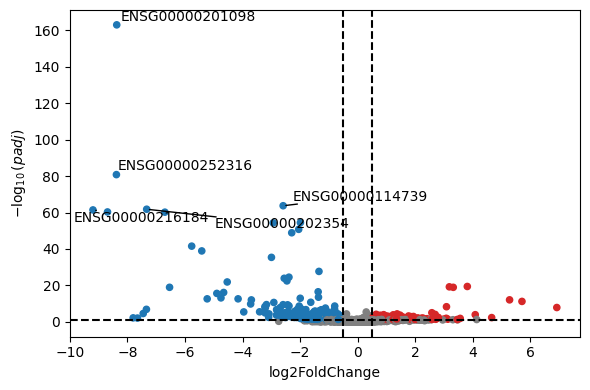

In [ ]:
dc.pl.volcano(
    de_df,
    x='log2FoldChange',
    y='padj',
    top=5,
    figsize=(6, 4)
)

In [ ]:
de_df.sort_values('padj').head()

,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj
ENSG00000201098,127.322068,-8.369909,0.305762,-27.648734,2.890313e-168,9.651332e-164
ENSG00000252316,23.712783,-8.381000,0.430666,-19.626624,9.160256e-86,1.529396e-81
ENSG00000114739,34.775923,-2.589421,0.149486,-17.491828,1.653658e-68,1.840631e-64
ENSG00000202354,87.996095,-7.329539,0.428796,-17.222426,1.802701e-66,1.504895e-62
ENSG00000216184,4.576211,-9.195289,0.826357,-17.158143,5.463242e-66,3.648572e-62


We want to label the top 5 genes by gene name instead of Ensembl ID. We will print the Ensembl IDs and convert them to gene names using a web tool.

In [ ]:
top_genes_df = de_df['padj'].nsmallest(5).index
top_genes = top_genes_df.tolist()
print("\n".join(top_genes))

ENSG00000201098
ENSG00000252316
ENSG00000114739
ENSG00000202354
ENSG00000216184


Re-label genes by gene name.

In [ ]:
ensembl_to_gene = {"ENSG00000114739": "ACVR2B", "ENSG00000201098": "RNY1",
                   "ENSG00000202354": "RNY3", "ENSG00000252316":"RNY4",
                   "ENSG00000216184":"AC048346.1"}

In [ ]:
old_index = de_df.index.tolist()
new_index = [ensembl_to_gene[i] if i in ensembl_to_gene else i for i in old_index]
de_df_relabeled = de_df.copy()
de_df_relabeled.index = new_index

Generate volcano plot.

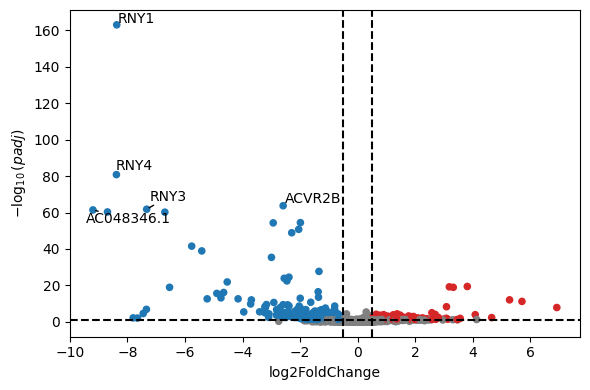

In [ ]:
dc.pl.volcano(
    de_df_relabeled,
    x='log2FoldChange',
    y='padj',
    top=5,
    figsize=(6, 4)
)

## Gene Panels

PAM50 is a 50-gene panel used to classify breast cancer subtypes, first presented in [Parker et al (2009)](https://ascopubs.org/doi/full/10.1200/JCO.2008.18.1370).

In [ ]:
pam50_genes = list()
with open(f"{filepath}/Data/Gene_Panels/pam50_gene_panel.txt") as f:
  for line in f:
    pam50_genes.append(line.strip())
pam50_genes.sort()
print(pam50_genes[:5])
print(len(pam50_genes))

['ACTR3B', 'ANLN', 'BAG1', 'BCL2', 'BIRC5']
50


Oncotype Dx is a 21-gene prognostic and predictive assay used to assess distant recurrence risk and the likelihood of adjuvant chemotherapy benefit. The 21 genes include 16 cancer-related genes and 5 control genes. This list of 16 genes comes from [Huang et al (2021)](https://pmc.ncbi.nlm.nih.gov/articles/PMC7837574/).

In [ ]:
oncotype_dx_genes = list()
with open(f"{filepath}/Data/Gene_Panels/oncotype_dx_gene_panel.txt") as f:
  for line in f:
    oncotype_dx_genes.append(line.strip())
oncotype_dx_genes.sort()
print(oncotype_dx_genes[:5])
print(len(oncotype_dx_genes))

['BAG1', 'BCL2', 'BIRC5', 'CCNB1', 'CD68']
16


MammaPrint and BluePrint are tests developed by the company Agendia. MammaPrint is a 70-gene prognostic and predictive assay used to assess distant recurrence risk, and BluePrint is an 80-gene panel used to classify breast cancer subtypes. We will use a table of MammaPrint and BluePrint genes categorized by the 10 cancer hallmarks from [Haan et al (2021)](https://pmc.ncbi.nlm.nih.gov/articles/PMC9299843/).

In [ ]:
mp_bp = pd.read_excel(f"{filepath}/Data/Gene_Panels/mammaprint_blueprint_genes.xlsx")
mp_bp.head(3)

,Hallmark,MP genes,BP genes
0,INVASION AND METASTASIS,"TSPYL5, DIAPH3, NUSAP1, FGF18, SCUBE2, FLT1, M...","AR, ESR1, GATA3, AFF3, DHRS2, GREB1, CDCA7, AB..."
1,IMMUNE DESTRUCTION,"DIAPH3, NUSAP1, MMP9, TGFB3, DCK, SLC2A3, PITR...","ESR1, GATA3, CDCA7, PGR, S100A8, DNALI1, VAV3,..."
2,CELLULAR ENERGETICS,"FLT1, OXCT1, MMP9, WISP1, GSTM3, COL4A2, DTL, ...","GREB1, MLPH, CDCA7, CA12, CHPT1, CELSR2, HK3, ..."


In [ ]:
mammaprint_genes, blueprint_genes = list(), list()
for hallmark, mp, bp in mp_bp.itertuples(index=False, name=None):
  for gene in mp.split(", "):
    mammaprint_genes.append(gene.strip())
  for gene in bp.split(", "):
    blueprint_genes.append(gene.strip())
mammaprint_genes = set(mammaprint_genes)
mammaprint_genes = sorted(list(mammaprint_genes))
blueprint_genes = set(blueprint_genes)
blueprint_genes = sorted(list(blueprint_genes))

In [ ]:
print(mammaprint_genes[:5])
print(len(mammaprint_genes))

['ALDH4A1', 'AP2B1', 'BBC3', 'C16orf95', 'CAPZB']
66


In [ ]:
print(blueprint_genes[:5])
print(len(blueprint_genes))

['ABAT', 'ABCC11', 'ACADSB', 'ACBD4', 'ADM']
80


First draft gene panel (not all genes are listed by gene symbol)

In [ ]:
draft_gene_panel = set(pam50_genes) | set(oncotype_dx_genes) | set(mammaprint_genes) | set(blueprint_genes)
draft_gene_panel = sorted(list(draft_gene_panel))
print(draft_gene_panel[:5])
print(len(draft_gene_panel))

['ABAT', 'ABCC11', 'ACADSB', 'ACBD4', 'ACTR3B']
188


Search the BioThings MyGene database to check which genes are listed by gene symbol.

In [ ]:
mg = get_client('gene')

In [ ]:
results = mg.querymany(draft_gene_panel, scopes='symbol', fields='ensembl.gene,symbol', species='human', returnall=True)

INFO:biothings.client:querying 1-188 ...
INFO:biothings.client:Finished.


Get the genes that are not listed by gene symbol and query them as aliases.

In [ ]:
genes_not_found = results['missing']
print(genes_not_found)
print(len(genes_not_found))

['CTSL2', 'ER', 'FAM214A', 'GPR126', 'HER2', 'HRASLS', 'JHDM1D-AS1', 'Ki67', 'ORC6L', 'PALM2-AKAP2', 'PPAPDC2', 'STK15', 'WISP1']
13


In [ ]:
results2 = mg.querymany(genes_not_found, scopes='alias', fields='symbol', species='human')

INFO:biothings.client:querying 1-13 ...
INFO:biothings.client:Finished.
INFO:biothings.client:Pass "returnall=True" to return complete lists of duplicate or missing query terms.


In [ ]:
for i in range(5):
  print(results2[i])

{'query': 'CTSL2', '_id': '1515', '_score': 20.90551, 'symbol': 'CTSV'}
{'query': 'ER', '_id': '2069', '_score': 20.347971, 'symbol': 'EREG'}
{'query': 'ER', '_id': '2099', '_score': 20.347971, 'symbol': 'ESR1'}
{'query': 'ER', '_id': '9780', '_score': 20.347971, 'symbol': 'PIEZO1'}
{'query': 'FAM214A', '_id': '56204', '_score': 16.058243, 'symbol': 'ATOSA'}


For the gene aliases not found in the MyGene search, we know that "ER" is gene ESR1, "Ki67" is MKI67. Rename all aliases to gene symbols:

In [ ]:
final_gene_panel = [g for g in draft_gene_panel]
rename_dict = {r.get("query"): r.get("symbol") for r in results2}
rename_dict["ER"] = "ESR1"
rename_dict["Ki67"] = "MKI67"
for k, v in rename_dict.items():
  final_gene_panel.remove(k)
  final_gene_panel.append(v)
final_gene_panel = set(final_gene_panel)
final_gene_panel = sorted(list(final_gene_panel))
print(len(final_gene_panel))

184


Convert final gene panel to Ensembl IDs

In [ ]:
ensembl_results = mg.querymany(final_gene_panel, scopes='symbol', fields='ensembl.gene', species='human')

INFO:biothings.client:querying 1-184 ...
INFO:biothings.client:Finished.


In [ ]:
for i in range(3):
  print(ensembl_results[i])

{'query': 'ABAT', '_id': '18', '_score': 17.597437, 'ensembl': {'gene': 'ENSG00000183044'}}
{'query': 'ABCC11', '_id': '85320', '_score': 19.667528, 'ensembl': {'gene': 'ENSG00000121270'}}
{'query': 'ACADSB', '_id': '36', '_score': 17.582834, 'ensembl': {'gene': 'ENSG00000196177'}}


In [ ]:
# for r in ensembl_results:
#   print(r)

After inspecting the full results, some of the genes map to multiple Ensembl IDs. We want to make sure we use the Ensembl IDs that are in the SILVER-seq dataset, so we will check these Ensembl IDs against those in the normal TPM dataset.

In [ ]:
multi_ids = dict()
for r in ensembl_results:
  ensembl_ids = r.get('ensembl')
  if len(ensembl_ids) > 1:
    multi_ids[r.get("query")] = [entry['gene'] for entry in ensembl_ids]
for k,v in multi_ids.items():
  print(k, v)

CMC2 ['ENSG00000103121', 'ENSG00000291948']
LILRB3 ['ENSG00000277816', 'ENSG00000275019', 'ENSG00000204577', 'ENSG00000274587']
LPCAT1 ['ENSG00000153395', 'ENSG00000275079']
MAPT ['ENSG00000276155', 'ENSG00000186868', 'ENSG00000277956']
MIR210HG ['ENSG00000247095', 'ENSG00000282810']
MMP11 ['ENSG00000099953', 'ENSG00000275365']
SERF1A ['ENSG00000172058', 'ENSG00000275581']
TMC4 ['ENSG00000277789', 'ENSG00000278363', 'ENSG00000277667', 'ENSG00000167608', 'ENSG00000274905', 'ENSG00000277996', 'ENSG00000276260', 'ENSG00000274384', 'ENSG00000274873', 'ENSG00000273722']


In [ ]:
normal_tpm = pd.read_csv(f"{filepath}/Data/pnas_normal_tpm.txt", sep="\t")
normal_tpm.head(3)

,N1,N2,N3,N4,N5,N6,N7,N8,N9,N10,...,N23,N24,N25,N26,N27,N28,N29,N30,N31,N32
ENSG00000000003,26.432148,17.260895,0.000000,69.795165,19.331552,0.000000,2.928341,53.467303,14.997727,25.816814,...,2.262858,20.126431,9.225788,4.707643,2.113035,20.452887,16.581454,9.340377,5.074037,4.109799
ENSG00000000005,24.817762,5.402219,7.557640,0.000000,0.000000,14.330953,0.000000,16.733900,14.081717,0.000000,...,12.747904,21.259324,0.000000,46.411223,0.000000,64.812467,52.544413,0.000000,100.046777,11.576360
ENSG00000000419,66.208114,0.000000,10.081027,0.000000,18.158365,9.557926,0.000000,0.000000,0.000000,0.000000,...,8.502123,18.905005,69.327173,0.000000,7.939198,19.211649,38.937911,35.094127,19.064423,30.883082


In [ ]:
dataset_genes = normal_tpm.index.tolist()
dataset_gene_set = set(dataset_genes)

In [ ]:
multi_gene_id_dict = dict()
for gene, ids in multi_ids.items():
  for ensembl_id in ids:
    if ensembl_id in dataset_gene_set:
      multi_gene_id_dict[gene] = ensembl_id
      continue
print(multi_gene_id_dict)

{'CMC2': 'ENSG00000103121', 'LILRB3': 'ENSG00000204577', 'LPCAT1': 'ENSG00000153395', 'MAPT': 'ENSG00000186868', 'MIR210HG': 'ENSG00000247095', 'MMP11': 'ENSG00000099953', 'SERF1A': 'ENSG00000172058', 'TMC4': 'ENSG00000167608'}


Now we will map each gene in the final 184-gene panel to its Ensembl ID.

In [ ]:
for i in range(3):
  print(ensembl_results[i])

{'query': 'ABAT', '_id': '18', '_score': 17.597437, 'ensembl': {'gene': 'ENSG00000183044'}}
{'query': 'ABCC11', '_id': '85320', '_score': 19.667528, 'ensembl': {'gene': 'ENSG00000121270'}}
{'query': 'ACADSB', '_id': '36', '_score': 17.582834, 'ensembl': {'gene': 'ENSG00000196177'}}


In [ ]:
final_gene_panel_ids = list()
for r in ensembl_results:
  if len(r.get('ensembl')) > 1:
    final_gene_panel_ids.append(multi_gene_id_dict[r.get('query')])
  else:
    final_gene_panel_ids.append(r.get('ensembl')['gene'])
print(final_gene_panel_ids[:5])
print(len(final_gene_panel_ids))

['ENSG00000183044', 'ENSG00000121270', 'ENSG00000196177', 'ENSG00000181513', 'ENSG00000133627']
184


In [ ]:
gene_panel_df = pd.DataFrame(final_gene_panel_ids)
gene_panel_df.head()

,0
0,ENSG00000183044
1,ENSG00000121270
2,ENSG00000196177
3,ENSG00000181513
4,ENSG00000133627


In [ ]:
gene_panel_df.to_csv(f"{filepath}/Data/Gene_Panels/feature_set_gene_panels.csv", index=None)

# Subtypes of human genes

Subtypes of human genes - microRNA (miRNA), protein-coding genes, and small Cajal body-specific RNA (scaRNA) - were downloaded from Ensembl Biomart.

In [ ]:
mirna_genes_df = pd.read_csv(f"{filepath}/Data/miRNA_genes.txt", sep="\t")
mirna_genes_df.head(3)

,Gene stable ID,Gene name
0,ENSG00000288126,MIR24-2
1,ENSG00000288183,MIR27A
2,ENSG00000288462,MIR23A


In [ ]:
mirna_genes_df.shape

(1945, 2)

In [ ]:
protein_coding_genes_df = pd.read_csv(f"{filepath}/Data/protein_coding_genes.txt", sep="\t")
protein_coding_genes_df.head(3)

,Gene stable ID,Gene name
0,ENSG00000198888,MT-ND1
1,ENSG00000198763,MT-ND2
2,ENSG00000198804,MT-CO1


In [ ]:
protein_coding_genes_df.shape

(23262, 2)

In [ ]:
scarna_genes_df = pd.read_csv(f"{filepath}/Data/scaRNA_genes.txt", sep="\t")
scarna_genes_df.head(3)

,Gene stable ID,Gene name
0,ENSG00000252143,NaN
1,ENSG00000252193,NaN
2,ENSG00000251733,SCARNA8


In [ ]:
scarna_genes_df.shape

(51, 2)

In [ ]:
mirna_genes = mirna_genes_df["Gene stable ID"].tolist()
protein_coding_genes = protein_coding_genes_df["Gene stable ID"].tolist()
scarna_genes = scarna_genes_df["Gene stable ID"].tolist()
mirna_genes, protein_coding_genes, scarna_genes = \
  set(mirna_genes), set(protein_coding_genes), set(scarna_genes)

In [ ]:
print(len(mirna_genes | protein_coding_genes | scarna_genes))

25258


# DoRothEA

Curate a feature set from BC-related TFs and their target genes based on DoRothEA gene regulatory network.

In [ ]:
# Dict of TFs : target genes (all listed by gene name)
def build_dorothea_dict(dorothea_levels):
  dorothea_df = dc.op.dorothea(organism="human", levels=dorothea_levels)
  dorothea_dict = dict()
  for tf, gene in dorothea_df.iloc[:,:2].itertuples(index=False, name=None):
      if tf not in dorothea_dict:
          dorothea_dict[tf] = set()
      dorothea_dict[tf].add(gene)
  return dorothea_dict

In [ ]:
tf_target_dict_a = build_dorothea_dict(["A"])
print(len(tf_target_dict_a))

335


In [ ]:
tf_target_dict_ab = build_dorothea_dict(["A", "B"])
print(len(tf_target_dict_ab))

367


In [ ]:
tf_target_dict_abc = build_dorothea_dict(["A", "B", "C"])
print(len(tf_target_dict_abc))

429


In [ ]:
with open(f"{filepath}/Data/TF-Decoupler-RegulatedGenes/breast_cancer_transcription_factors.txt") as f:
  bc_tf_list = [line.strip() for line in f]

In [ ]:
print(len(bc_tf_list))
print(bc_tf_list[:5])

37
['NFKB1', 'AP1', 'STAT3', 'HIF1A', 'MYC']


In [ ]:
def build_gene_set(tf_list, dorothea_dict):
  target_gene_set = set()
  tfs_not_found = list()
  for tf in tf_list:
    if tf in dorothea_dict:
      target_gene_set.add(tf)
      target_gene_set.update(set(dorothea_dict[tf]))
    else:
      tfs_not_found.append(tf)
  print(f"Number of TFs found in DoRothEA: {len(tf_list) - len(tfs_not_found)}")
  print(f"TFs not found in DoRothEA: {tfs_not_found}")
  return target_gene_set

In [ ]:
bc_genes_a = build_gene_set(bc_tf_list, tf_target_dict_a)
print(len(bc_genes_a))

Number of TFs found in DoRothEA: 24
TFs not found in DoRothEA: ['AP1', 'COPS5', 'HDAC2', 'NONO', 'SIM2', 'PTMA', 'ZNF706', 'ZNF250', 'ALX3', 'HNRNPD', 'TBPL1', 'ARNT2', 'ZNF652']
1506


In [ ]:
bc_genes_ab = build_gene_set(bc_tf_list, tf_target_dict_ab)
print(len(bc_genes_ab))

Number of TFs found in DoRothEA: 24
TFs not found in DoRothEA: ['AP1', 'COPS5', 'HDAC2', 'NONO', 'SIM2', 'PTMA', 'ZNF706', 'ZNF250', 'ALX3', 'HNRNPD', 'TBPL1', 'ARNT2', 'ZNF652']
2704


In [ ]:
bc_genes_abc = build_gene_set(bc_tf_list, tf_target_dict_abc)
print(len(bc_genes_abc))

Number of TFs found in DoRothEA: 24
TFs not found in DoRothEA: ['AP1', 'COPS5', 'HDAC2', 'NONO', 'SIM2', 'PTMA', 'ZNF706', 'ZNF250', 'ALX3', 'HNRNPD', 'TBPL1', 'ARNT2', 'ZNF652']
4128


Convert to Ensembl IDs

In [ ]:
mg = get_client('gene')

In [ ]:
ensembl_results_a = mg.querymany(bc_genes_a, scopes='symbol', fields='ensembl.gene', species='human')

INFO:biothings.client:querying 1-1000 ...
INFO:biothings.client:querying 1001-1506 ...
INFO:biothings.client:Finished.
INFO:biothings.client:Pass "returnall=True" to return complete lists of duplicate or missing query terms.


In [ ]:
multi_ids = dict()
for r in ensembl_results_a:
  ensembl_ids = r.get('ensembl')
  if ensembl_ids:
    if len(ensembl_ids) > 1:
      multi_ids[r.get("query")] = [entry['gene'] for entry in ensembl_ids]
print(len(multi_ids))

94


In [ ]:
normal_tpm = pd.read_csv(f"{filepath}/Data/pnas_normal_tpm.txt", sep="\t")
dataset_genes = normal_tpm.index.tolist()
dataset_gene_set = set(dataset_genes)

In [ ]:
multi_gene_id_dict = dict()
for gene, ids in multi_ids.items():
  for ensembl_id in ids:
    if ensembl_id in dataset_gene_set:
      multi_gene_id_dict[gene] = ensembl_id
      continue
print(len(multi_gene_id_dict))

94


In [ ]:
final_regulon_gene_ids = list()
not_found_genes = list()
for r in ensembl_results_a:
  ensembl_ids = r.get('ensembl')
  if ensembl_ids:
    if len(ensembl_ids) > 1:
      final_regulon_gene_ids.append(multi_gene_id_dict[r.get('query')])
    else:
      final_regulon_gene_ids.append(r.get('ensembl')['gene'])
  else:
    not_found_genes.append(r.get('query'))
    print(r)

{'query': 'GAS8', 'notfound': True}
{'query': 'SLC9A3R2', 'notfound': True}
{'query': 'HSP90AA2P', '_id': '3324', '_score': 8.521434}
{'query': 'TRA', '_id': '6955', '_score': 24.05106}
{'query': 'TRB', '_id': '6957', '_score': 25.894917}


-  Gene SLC9A3R2 is an alias for NHERF2 which has Ensembl ID ENSG00000065054
-  Gene GAS8 has Ensembl ID ENSG00000141013
-  Gene HSP90AA2P has Ensembl ID ENSG00000224411
-  Genes TRA and TRB do not have Ensembl IDs
-  CENPJ = CPAP = ENSG00000151849
-  FAM172A = ARB2A = ENSG00000113391
-  KIAA1522 = NHSL3 = ENSG00000162522
-  OFCC1 = ENSG00000181355
-  SOGA1 = MTCL2 = ENSG00000149639
-  SUMO1P1 = ENSG00000241721

In [ ]:
final_regulon_gene_ids += ["ENSG00000065054", "ENSG00000141013", "ENSG00000224411"]
final_regulon_gene_ids = sorted(list(set(final_regulon_gene_ids)))
print(len(final_regulon_gene_ids))

1504


In [ ]:
regulon_genes = pd.DataFrame(final_regulon_gene_ids)

In [ ]:
regulon_genes.to_csv(f"{filepath}/Data/TF-Decoupler-RegulatedGenes/feature_set_regulons.csv", index=None)

Confidence levels AB and ABC

In [ ]:
ensembl_results_ab = mg.querymany(bc_genes_ab, scopes='symbol', fields='ensembl.gene', species='human')

INFO:biothings.client:querying 1-1000 ...
INFO:biothings.client:querying 1001-2000 ...
INFO:biothings.client:querying 2001-2704 ...
INFO:biothings.client:Finished.
INFO:biothings.client:Pass "returnall=True" to return complete lists of duplicate or missing query terms.


In [ ]:
ensembl_results_abc = mg.querymany(bc_genes_abc, scopes='symbol', fields='ensembl.gene', species='human')

INFO:biothings.client:querying 1-1000 ...
INFO:biothings.client:querying 1001-2000 ...
INFO:biothings.client:querying 2001-3000 ...
INFO:biothings.client:querying 3001-4000 ...
INFO:biothings.client:querying 4001-4128 ...
INFO:biothings.client:Finished.
INFO:biothings.client:Pass "returnall=True" to return complete lists of duplicate or missing query terms.


In [ ]:
multi_ids = dict()
for r in ensembl_results_abc:
  ensembl_ids = r.get('ensembl')
  if ensembl_ids:
    if len(ensembl_ids) > 1:
      multi_ids[r.get("query")] = [entry['gene'] for entry in ensembl_ids]
print(len(multi_ids))

232


In [ ]:
normal_tpm = pd.read_csv(f"{filepath}/Data/pnas_normal_tpm.txt", sep="\t")
dataset_genes = normal_tpm.index.tolist()
dataset_gene_set = set(dataset_genes)

In [ ]:
multi_gene_id_dict = dict()
for gene, ids in multi_ids.items():
  for ensembl_id in ids:
    if ensembl_id in dataset_gene_set:
      multi_gene_id_dict[gene] = ensembl_id
      continue
print(len(multi_gene_id_dict))

232


In [ ]:
final_regulon_gene_ids = list()
not_found_genes = list()
for r in ensembl_results_abc:
  ensembl_ids = r.get('ensembl')
  if ensembl_ids:
    if len(ensembl_ids) > 1:
      final_regulon_gene_ids.append(multi_gene_id_dict[r.get('query')])
    else:
      final_regulon_gene_ids.append(r.get('ensembl')['gene'])
  else:
    not_found_genes.append(r.get('query'))
    print(r)

{'query': 'C14orf28', 'notfound': True}
{'query': 'C9orf64', 'notfound': True}
{'query': 'HSP90AA2P', '_id': '3324', '_score': 8.521434}
{'query': 'KIAA2026', 'notfound': True}
{'query': 'CENPJ', 'notfound': True}
{'query': 'TRB', '_id': '6957', '_score': 25.894917}
{'query': 'TTC26', 'notfound': True}
{'query': 'FAM172A', 'notfound': True}
{'query': 'KIAA1522', 'notfound': True}
{'query': 'PRPF4B', 'notfound': True}
{'query': 'GAS8', 'notfound': True}
{'query': 'SLC9A3R2', 'notfound': True}
{'query': 'FAM104A', 'notfound': True}
{'query': 'OFCC1', '_id': '266553', '_score': 6.0658436}
{'query': 'TRA', '_id': '6955', '_score': 24.05106}
{'query': 'SOGA1', 'notfound': True}
{'query': 'SLC35C2', 'notfound': True}
{'query': 'SOGA3', 'notfound': True}
{'query': 'TDGF1', 'notfound': True}
{'query': 'SUMO1P1', '_id': '391257', '_score': 8.521434}


In [ ]:
not_found_results_abc = mg.querymany(not_found_genes, scopes='alias', fields='ensembl.gene', species='human')

INFO:biothings.client:querying 1-20 ...
INFO:biothings.client:Finished.
INFO:biothings.client:Pass "returnall=True" to return complete lists of duplicate or missing query terms.


In [ ]:
found_ids = list()
for r in not_found_results_abc:
  if 'ensembl' in r:
    found_ids.append(r.get('ensembl')['gene'])
  else:
    print(r)
print(len(found_ids))

{'query': 'HSP90AA2P', 'notfound': True}
{'query': 'OFCC1', 'notfound': True}
{'query': 'SUMO1P1', 'notfound': True}
18


-  Gene SLC9A3R2 is an alias for NHERF2 which has Ensembl ID ENSG00000065054
-  Gene GAS8 has Ensembl ID ENSG00000141013
-  Gene HSP90AA2P has Ensembl ID ENSG00000224411
-  Genes TRA and TRB do not have Ensembl IDs
-  CENPJ = CPAP = ENSG00000151849
-  FAM172A = ARB2A = ENSG00000113391
-  KIAA1522 = NHSL3 = ENSG00000162522
-  OFCC1 = ENSG00000181355
-  SOGA1 = MTCL2 = ENSG00000149639
-  SUMO1P1 = ENSG00000241721

In [ ]:
final_regulon_gene_ids += found_ids
final_regulon_gene_ids += ["ENSG00000224411", "ENSG00000181355", "ENSG00000241721"]

In [ ]:
print(len(final_regulon_gene_ids))
print(final_regulon_gene_ids[:5])

4133
['ENSG00000160712', 'ENSG00000137496', 'ENSG00000100296', 'ENSG00000104133', 'ENSG00000116670']


In [ ]:
final_regulon_gene_ids = sorted(list(set(final_regulon_gene_ids)))
print(len(final_regulon_gene_ids))

4130


In [ ]:
regulon_genes = pd.DataFrame(final_regulon_gene_ids)
regulon_genes.head()

,0
0,ENSG00000102144
1,ENSG00000135333
2,ENSG00000165556
3,ENSG00000112294
4,ENSG00000154727


In [ ]:
regulon_genes.to_csv(f"{filepath}/Data/TF-Decoupler-RegulatedGenes/feature_set_regulons.csv", index=None)

In [ ]:
regulon_genes_read = pd.read_csv(f"{filepath}/Data/TF-Decoupler-RegulatedGenes/feature_set_regulons.csv")
regulon_genes_read.head()

,0
0,ENSG00000102144
1,ENSG00000135333
2,ENSG00000165556
3,ENSG00000112294
4,ENSG00000154727


In [ ]:
regulon_genes_med_conf = pd.DataFrame(final_regulon_gene_ids)
regulon_genes_med_conf.head()

,0
0,ENSG00000160712
1,ENSG00000137496
2,ENSG00000100296
3,ENSG00000116670
4,ENSG00000110047


In [ ]:
regulon_genes_med_conf.to_csv(f"{filepath}/Data/TF-Decoupler-RegulatedGenes/feature_set_regulons_med_confidence.csv", index=None)

In [ ]:
regulon_genes_conf_abc = pd.DataFrame(final_regulon_gene_ids)
regulon_genes_conf_abc.head()

,0
0,55872
1,ENSG00000000003
2,ENSG00000000938
3,ENSG00000001561
4,ENSG00000001626


In [ ]:
regulon_genes_conf_abc.shape

(4130, 1)

In [ ]:
regulon_genes_conf_abc.to_csv(f"{filepath}/Data/TF-Decoupler-RegulatedGenes/feature_set_regulons_confidence_abc.csv", index=None)